## GANs Convolucionales

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

In [3]:
# CARGAR FASHION MNIST
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_train.shape

(55000, 28, 28)

### Arq Convolucional

Las convoluciones vienen a darle mas capacidad generativa a las GANs. Existen algunas recomendaciones para usar convs.

- No use pooling layers, mejor se usa strides.
- Se debe usar Batch Normalization con excepcion de la capa de salida del generador y la capa de entrada del discriminador.
- No es aconseable usar capas totalmente conectadas. Entonces el dropout ayuda.
- ReLU o LeakyReLU se usan en todas las capas excepto en las capas de salida. El generador usa tanh y el discriminador sigmoid.

Estas recomendaciones funcionan bien en general pero no en todos los casos. Hacer tunning de un modelo GAN convolucional puede ser muy laborioso (dolor de jupa!)

In [4]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh"),
])
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

Se reduce el dataset X_train en tamano y se normaliza el canal

In [5]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # reshape and rescale

In [6]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              
        for X_batch in dataset:
            # Fase 1 - entrenar el discriminador
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # Fase 2 - Se entrena el generador.
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8)                     
        plt.show()                                                    

Epoch 1/50


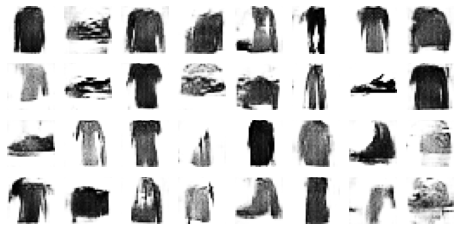

Epoch 2/50


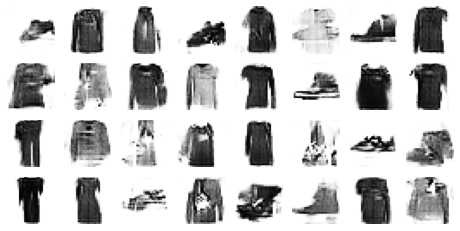

Epoch 3/50


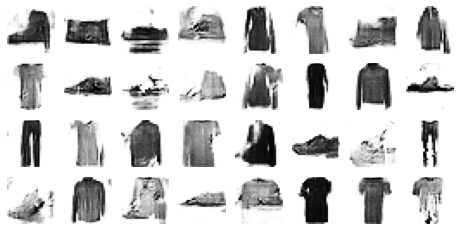

Epoch 4/50


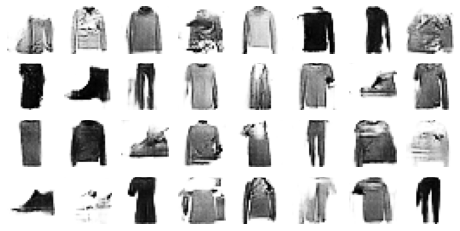

Epoch 5/50


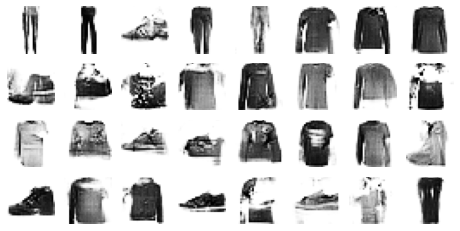

Epoch 6/50


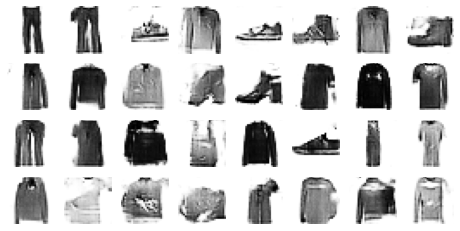

Epoch 7/50


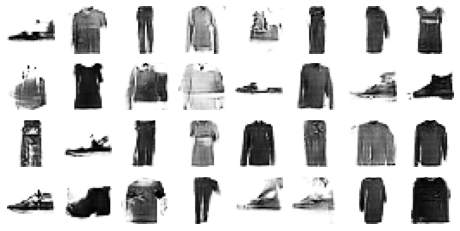

Epoch 8/50


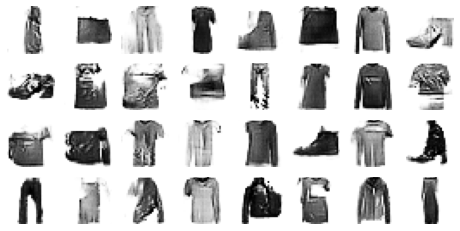

Epoch 9/50


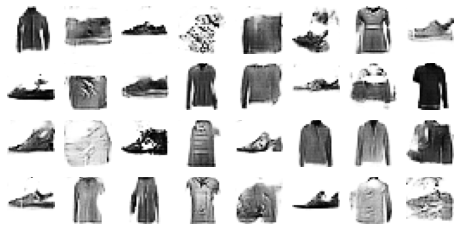

Epoch 10/50


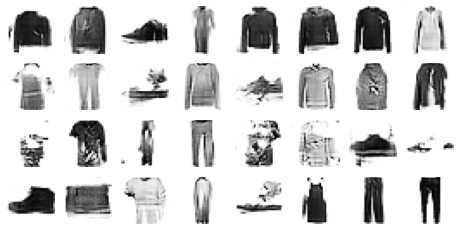

Epoch 11/50


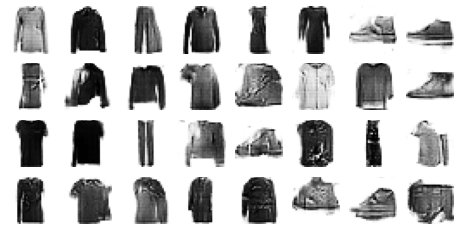

Epoch 12/50


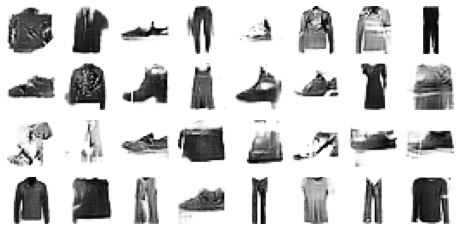

Epoch 13/50


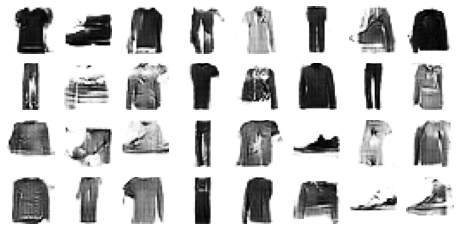

Epoch 14/50


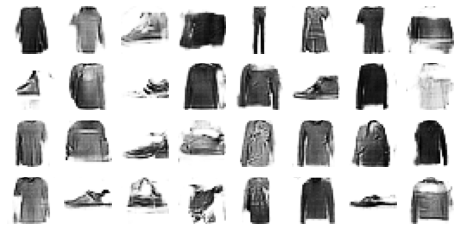

Epoch 15/50


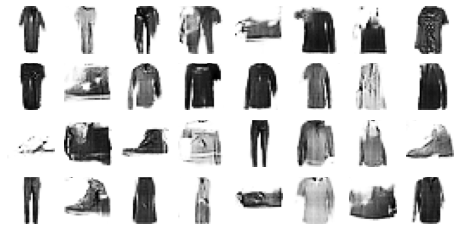

Epoch 16/50


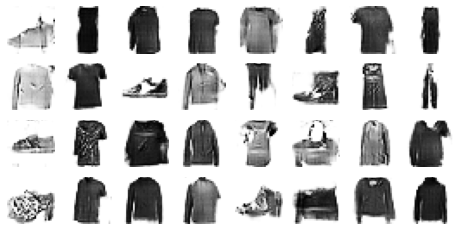

Epoch 17/50


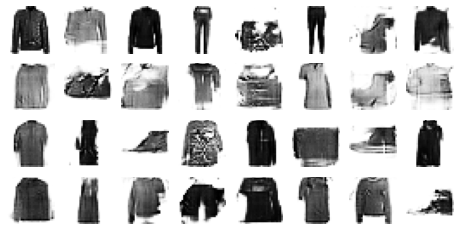

Epoch 18/50


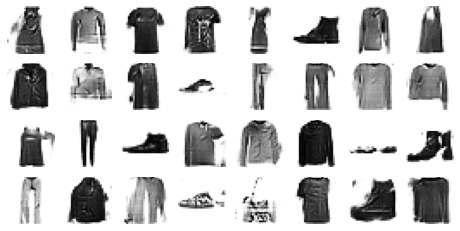

Epoch 19/50


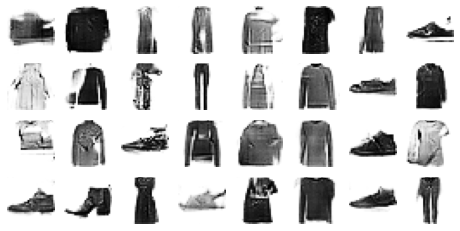

Epoch 20/50


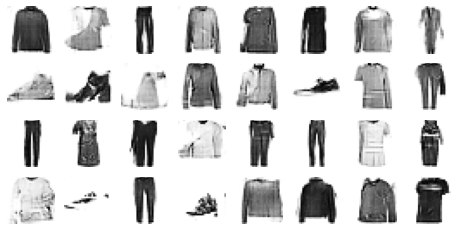

Epoch 21/50


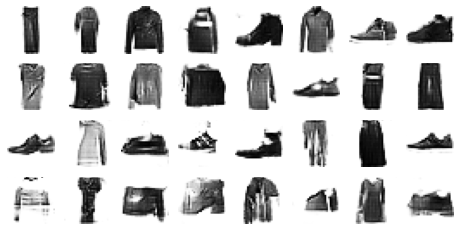

Epoch 22/50


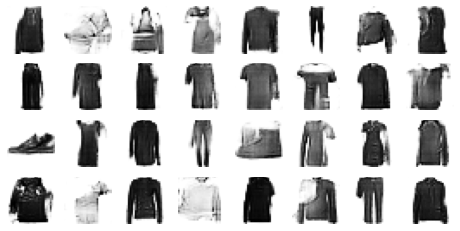

Epoch 23/50


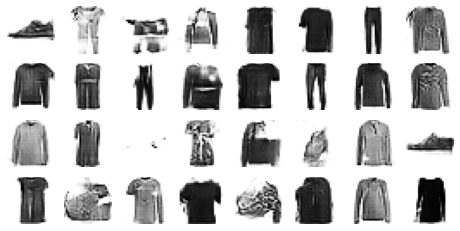

Epoch 24/50


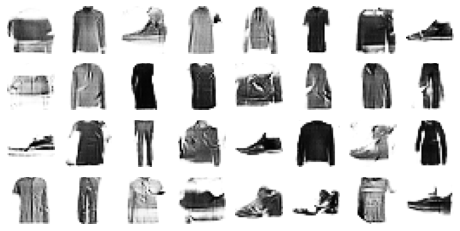

Epoch 25/50


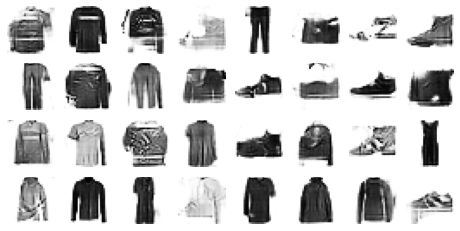

Epoch 26/50


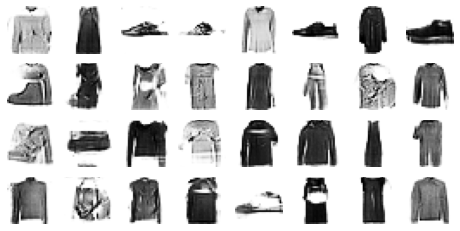

Epoch 27/50


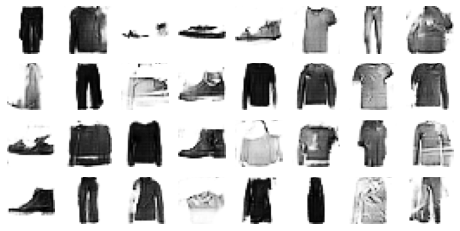

Epoch 28/50


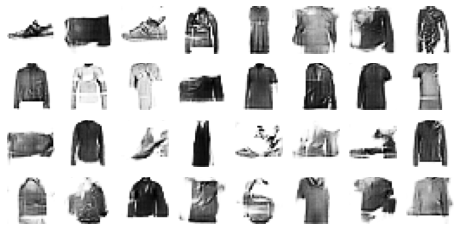

Epoch 29/50


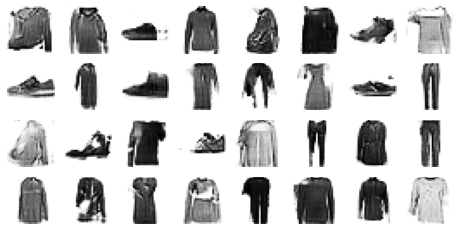

Epoch 30/50


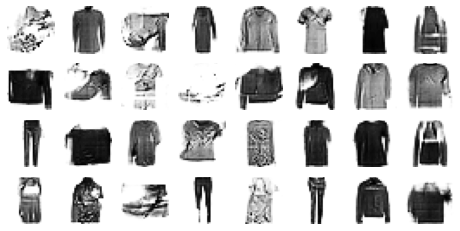

Epoch 31/50


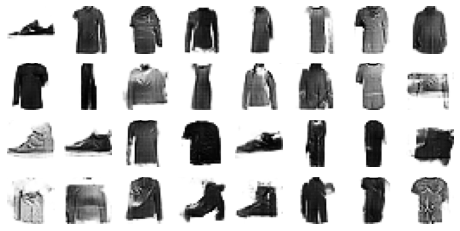

Epoch 32/50


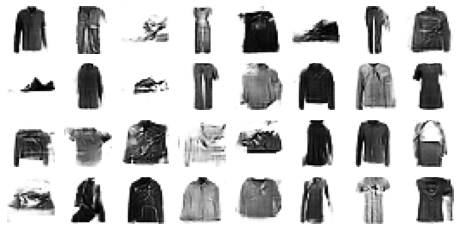

Epoch 33/50


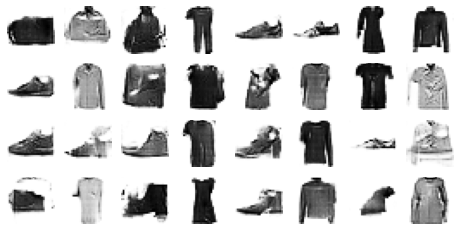

Epoch 34/50


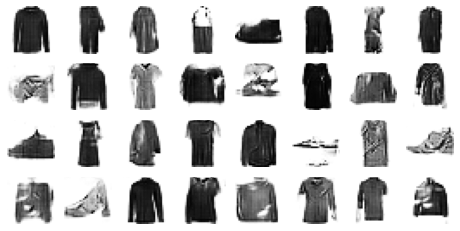

Epoch 35/50


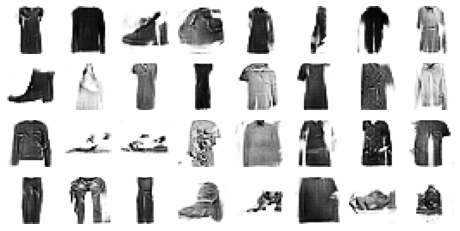

Epoch 36/50


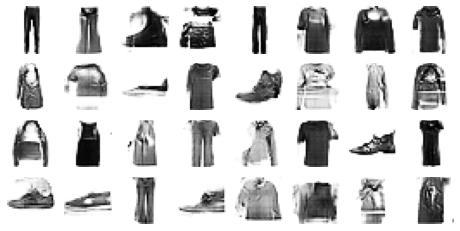

Epoch 37/50


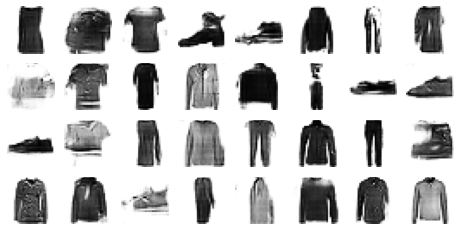

Epoch 38/50


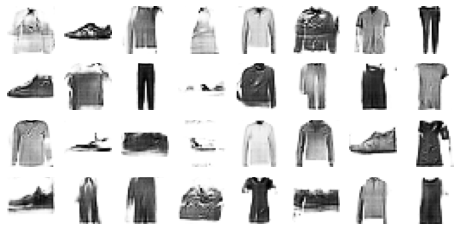

Epoch 39/50


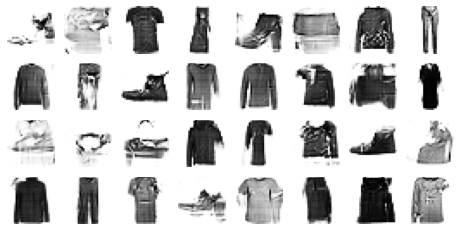

Epoch 40/50


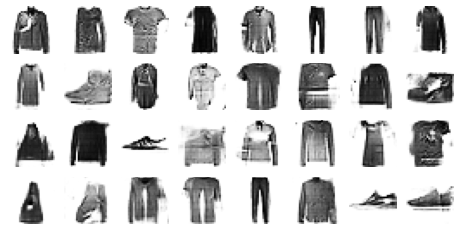

Epoch 41/50


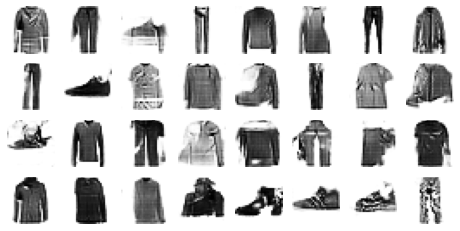

Epoch 42/50


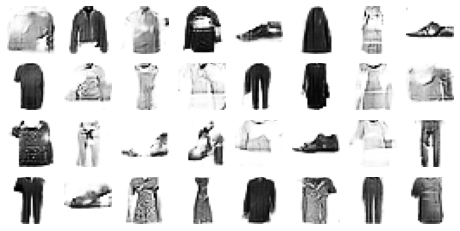

Epoch 43/50


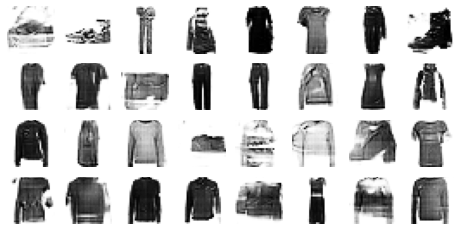

Epoch 44/50


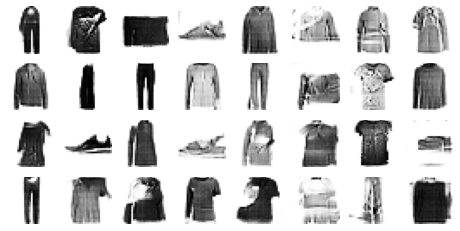

Epoch 45/50


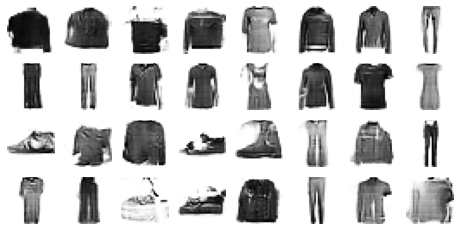

Epoch 46/50


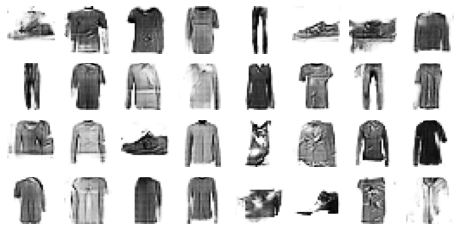

Epoch 47/50


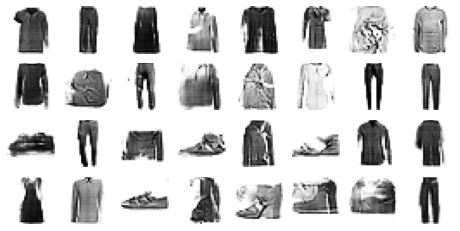

Epoch 48/50


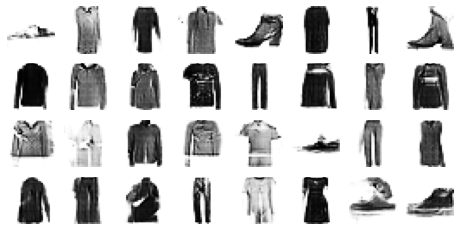

Epoch 49/50


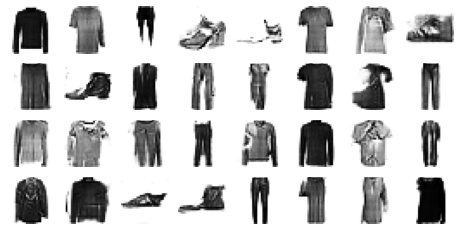

Epoch 50/50


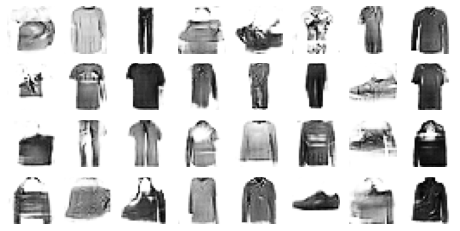

In [7]:
train_gan(gan, dataset, batch_size, codings_size)